# Aircraft Model Training and Building
This notebook replaces the functionality of `train_and_build.py`.
It handles data loading, cleaning, feature engineering, model training, and recommender system building.

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [4]:
# Constants
DATA_PATH = os.path.join("data", "aircraft-data_nov_dec.csv")
MODELS_DIR = "models"

def ensure_dirs():
    os.makedirs(MODELS_DIR, exist_ok=True)

ensure_dirs()

In [5]:
def load_data(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at: {path}")
    df = pd.read_csv(path)
    return df

print("Loading dataset...")
raw = load_data(DATA_PATH)
print("Raw shape:", raw.shape)
raw.head()

Loading dataset...
Raw shape: (30947, 14)


,flight,tail_number,long,lat,alt,manufacturer,model,reg_expiration,reg_owner,reg_city,reg_state,squawk,mph,spotted
0,SIS300,N300NJ,-118.213,34.5823,20175,BOMBARDIER INC,BD-100-1A10,1/31/2024,PUNTA PACIFICO I LLC,BAKERSFIELD,CALIFORNIA,1077.0,474,11/7/2022 13:30
1,UAL1434,N67501,-117.937,34.6038,36700,BOEING,737-9,4/30/2024,UNITED AIRLINES INC,CHICAGO,ILLINOIS,7730.0,523,11/7/2022 13:30
2,SWA3287,N483WN,-118.035,34.6345,13225,BOEING,737-7H4,8/31/2024,SOUTHWEST AIRLINES CO,DALLAS,TEXAS,4770.0,380,11/7/2022 13:30
3,AAL2059,N660AW,-118.075,34.4643,33750,AIRBUS INDUSTRIE,A320-232,2/29/2024,US BANK NA TRUSTEE,BOSTON,MASSACHUSETTS,1751.0,527,11/7/2022 13:30
4,N84PJ,N84PJ,-117.756,34.6002,34725,DASSAULT,FALCON 2000EX,12/31/2024,HAMPTON AIRWAYS INC,SELLERSBURG,INDIANA,6054.0,525,11/7/2022 13:40


## Exploratory Data Analysis (Before Cleaning)

Generating Raw Data Visualizations...
Missing Value Counts (Raw):
 flight              32
tail_number          0
long                 0
lat                  0
alt                  0
manufacturer       762
model              762
reg_expiration     989
reg_owner          763
reg_city           607
reg_state          610
squawk            1894
mph                  0
spotted              0
dtype: int64


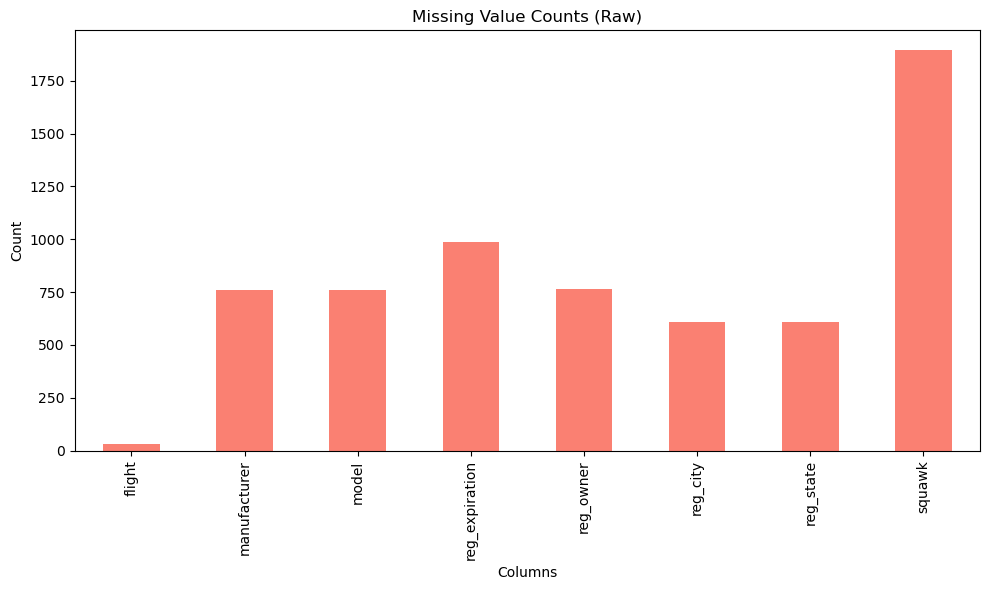

Saved missing values plot: missing_values_raw.png


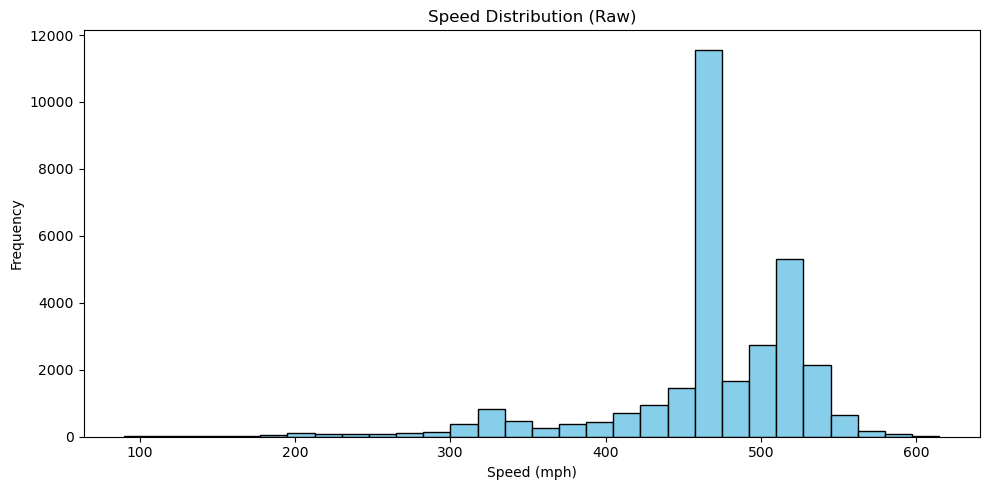

Saved speed distribution plot: speed_distribution_raw.png


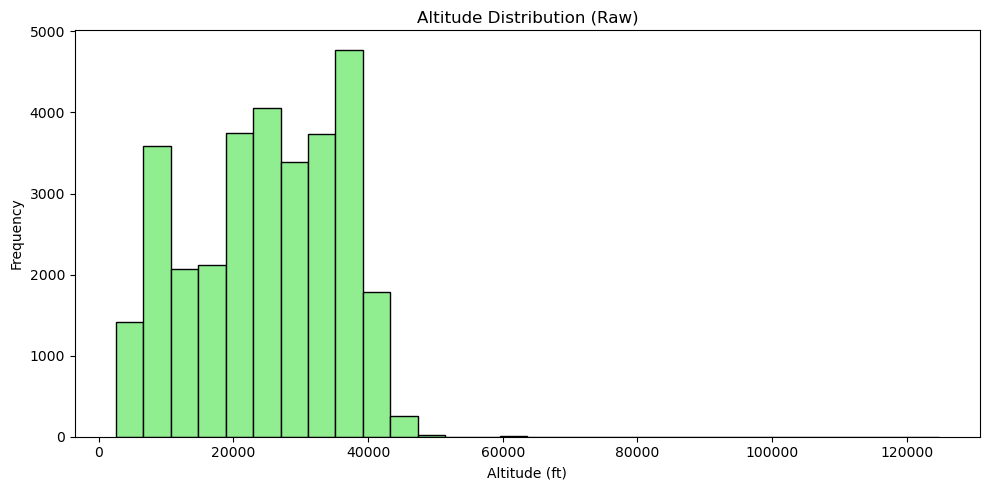

Saved altitude distribution plot: altitude_distribution_raw.png


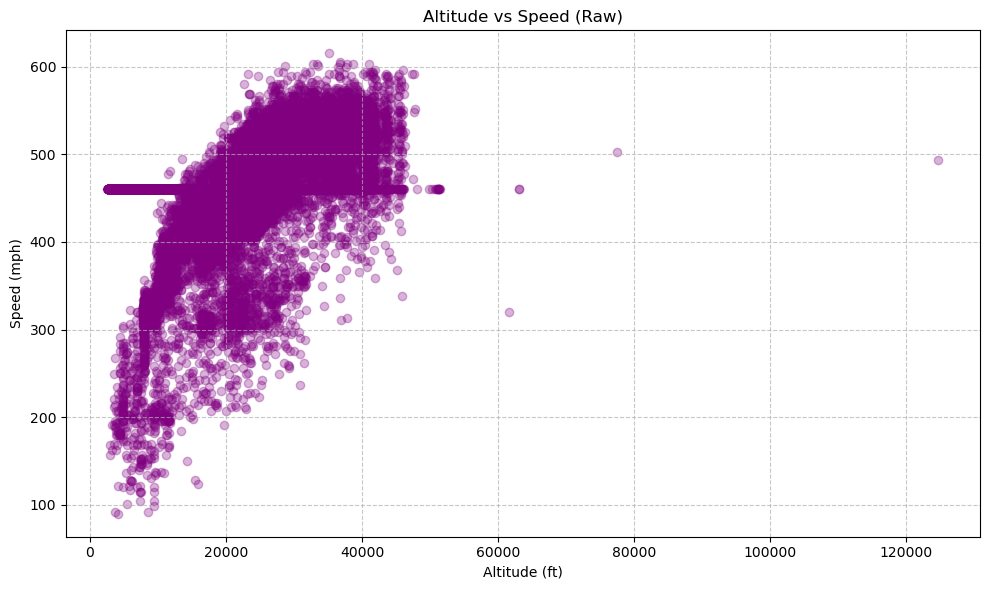

Saved altitude vs speed plot: altitude_vs_speed_raw.png


In [6]:
# Exploratory Data Analysis (Before Cleaning)
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Plots directory exists
PLOTS_DIR = os.path.join("static", "Plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

def plot_missing_values(df, stage="raw"):
    """Visualizes missing values in the dataframe."""
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print(f"No missing values found in {stage} data.")
        return
    
    plt.figure(figsize=(10, 6))
    missing.plot(kind='bar', color='salmon')
    plt.title(f"Missing Value Counts ({stage.capitalize()})")
    plt.xlabel("Columns")
    plt.ylabel("Count")
    plt.tight_layout()
    filename = f"missing_values_{stage}.png"
    plt.savefig(os.path.join(PLOTS_DIR, filename), dpi=150)
    plt.show()
    print(f"Saved missing values plot: {filename}")

def plot_distributions(df, stage="raw"):
    """Plots distributions of Altitude and Speed."""
    # Speed Distribution
    plt.figure(figsize=(10, 5))
    plt.hist(df['mph'].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Speed Distribution ({stage.capitalize()})")
    plt.xlabel("Speed (mph)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    filename = f"speed_distribution_{stage}.png"
    plt.savefig(os.path.join(PLOTS_DIR, filename), dpi=150)
    plt.show() 
    print(f"Saved speed distribution plot: {filename}")

    # Altitude Distribution
    plt.figure(figsize=(10, 5))
    plt.hist(df['alt'].dropna(), bins=30, color='lightgreen', edgecolor='black')
    plt.title(f"Altitude Distribution ({stage.capitalize()})")
    plt.xlabel("Altitude (ft)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    filename = f"altitude_distribution_{stage}.png"
    plt.savefig(os.path.join(PLOTS_DIR, filename), dpi=150)
    plt.show()
    print(f"Saved altitude distribution plot: {filename}")

def plot_relationships(df, stage="raw"):
    """Plots relationships between variables."""
    # Altitude vs Speed
    plt.figure(figsize=(10, 6))
    plt.scatter(df['alt'], df['mph'], alpha=0.3, color='purple')
    plt.title(f"Altitude vs Speed ({stage.capitalize()})")
    plt.xlabel("Altitude (ft)")
    plt.ylabel("Speed (mph)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    filename = f"altitude_vs_speed_{stage}.png"
    plt.savefig(os.path.join(PLOTS_DIR, filename), dpi=150)
    plt.show()
    print(f"Saved altitude vs speed plot: {filename}")

# Run Raw EDA
print("Generating Raw Data Visualizations...")
print("Missing Value Counts (Raw):\n", raw.isnull().sum())
plot_missing_values(raw, "raw")
plot_distributions(raw, "raw")
plot_relationships(raw, "raw")


In [7]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Standardize expected column names
    expected = ["tail_number", "alt", "mph", "lat", "long"]
    for col in expected:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}'. Found: {df.columns.tolist()}")

    # Convert numeric columns
    for col in ["alt", "mph", "lat", "long"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Convert timestamp if exists
    if "spotted" in df.columns:
        df["spotted"] = pd.to_datetime(df["spotted"], errors="coerce")

    # Drop duplicates
    df = df.drop_duplicates()

    # Drop rows missing core fields
    df = df.dropna(subset=["tail_number", "alt", "mph", "lat", "long"])

    # Domain rules to remove unrealistic values
    df = df[(df["alt"] >= 0) & (df["alt"] <= 60000)]
    df = df[(df["mph"] >= 0) & (df["mph"] <= 700)]

    # Fill missing categorical columns
    for col in ["manufacturer", "model", "reg_state"]:
        if col in df.columns:
            df[col] = df[col].astype(str).fillna("UNKNOWN").str.strip()
        else:
            df[col] = "UNKNOWN"

    return df

print("Cleaning dataset...")
df = clean_data(raw)
print("Cleaned shape:", df.shape)

Cleaning dataset...
Cleaned shape: (30942, 14)


## Exploratory Data Analysis (After Cleaning)

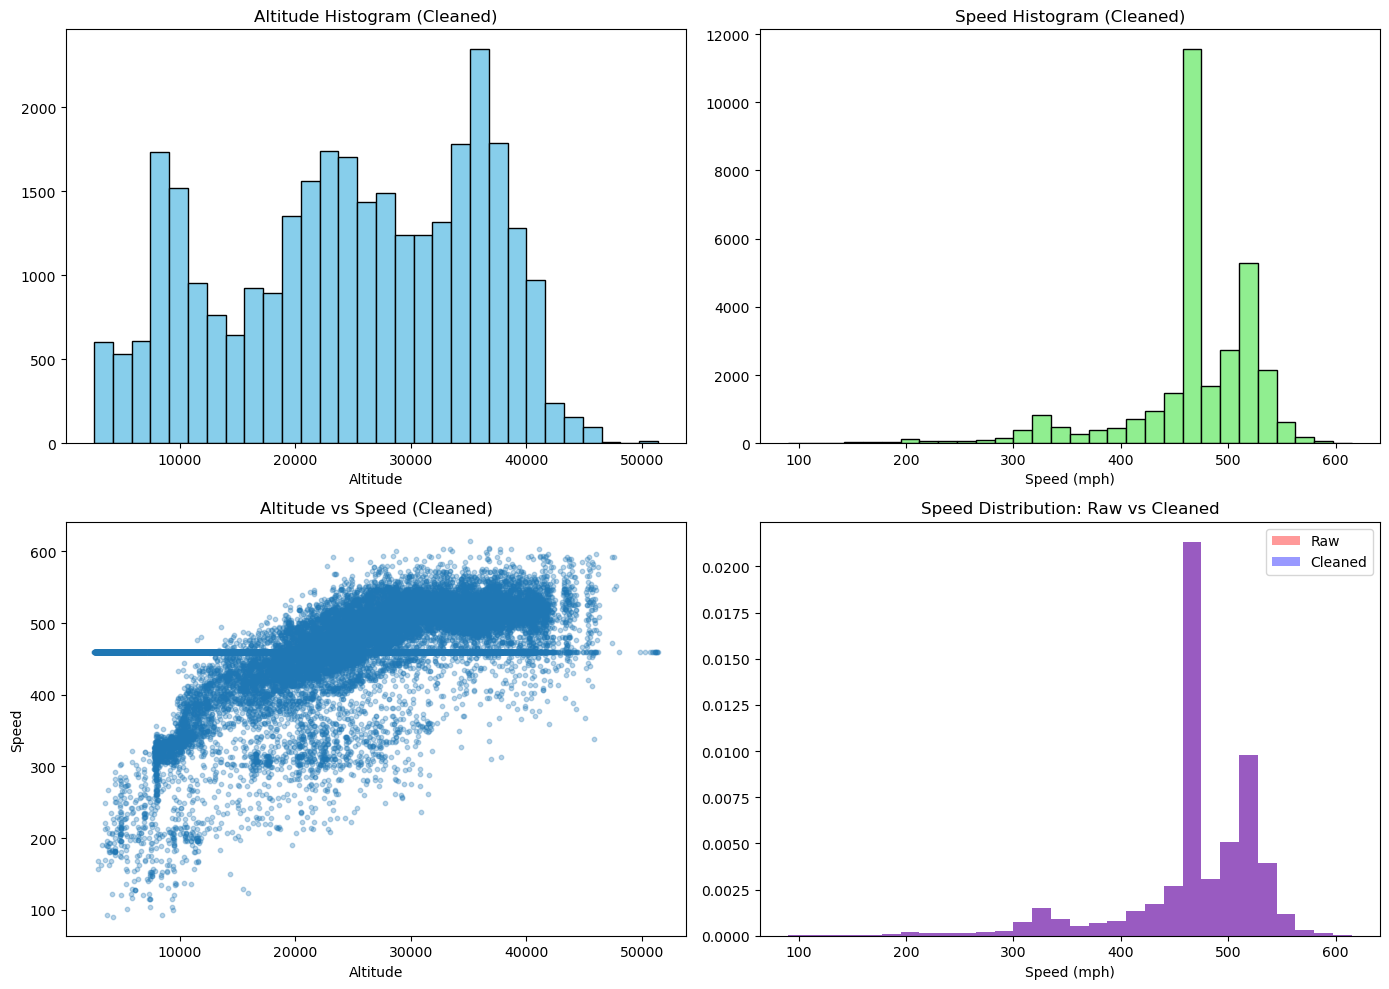

In [8]:
def plot_eda_after(cleaned_df, raw_df):
    plt.figure(figsize=(14, 10))
    
    # 1. Cleaned altitude histogram
    plt.subplot(2, 2, 1)
    plt.hist(cleaned_df["alt"], bins=30, color="skyblue", edgecolor="black")
    plt.title("Altitude Histogram (Cleaned)")
    plt.xlabel("Altitude")
    
    # 2. Cleaned speed histogram
    plt.subplot(2, 2, 2)
    plt.hist(cleaned_df["mph"], bins=30, color="lightgreen", edgecolor="black")
    plt.title("Speed Histogram (Cleaned)")
    plt.xlabel("Speed (mph)")
    
    # 3. Altitude vs Speed Scatter
    plt.subplot(2, 2, 3)
    plt.scatter(cleaned_df["alt"], cleaned_df["mph"], alpha=0.3, s=10)
    plt.title("Altitude vs Speed (Cleaned)")
    plt.xlabel("Altitude")
    plt.ylabel("Speed")
    
    # 4. Before vs After Speed Comparison
    plt.subplot(2, 2, 4)
    plt.hist(raw_df["mph"].dropna(), bins=30, alpha=0.4, label="Raw", color="red", density=True)
    plt.hist(cleaned_df["mph"], bins=30, alpha=0.4, label="Cleaned", color="blue", density=True)
    plt.title("Speed Distribution: Raw vs Cleaned")
    plt.xlabel("Speed (mph)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_eda_after(df, raw)
# COMMENTS:
# Data quality has improved after cleaning. Unrealistic values and missing data have been handled.
# The distributions now reflect more realistic aircraft performance metrics.

In [9]:
def mode_or_unknown(s: pd.Series) -> str:
    s = s.dropna().astype(str).str.strip()
    if len(s) == 0:
        return "UNKNOWN"
    return s.value_counts().index[0]

def build_aircraft_profiles(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Flight count proxy
    if "flight" in df.columns:
        df["_flight_count_proxy"] = df["flight"].notna().astype(int)
        count_col = "_flight_count_proxy"
    else:
        df["_flight_count_proxy"] = 1
        count_col = "_flight_count_proxy"

    profiles = (
        df.groupby("tail_number", as_index=False)
          .agg(
              avg_alt=("alt", "mean"),
              avg_mph=("mph", "mean"),
              mean_lat=("lat", "mean"),
              mean_long=("long", "mean"),
              flight_count=(count_col, "sum"),
              manufacturer=("manufacturer", mode_or_unknown),
              model=("model", mode_or_unknown),
              reg_state=("reg_state", mode_or_unknown),
          )
    )

    profiles["log_flight_count"] = np.log1p(profiles["flight_count"])
    return profiles

print("Building aircraft profiles...")
profiles = build_aircraft_profiles(df)
print("Profiles shape:", profiles.shape)
profiles.head()

Building aircraft profiles...
Profiles shape: (8475, 10)


,tail_number,avg_alt,avg_mph,mean_lat,mean_long,flight_count,manufacturer,model,reg_state,log_flight_count
0,N10000J,20350.000000,314.800000,34.616820,-118.198200,5,nan,nan,nan,1.791759
1,N10003,6750.000000,460.000000,34.723875,-117.982000,4,TEXAS HELICOPTER CORP,OH-13H/M74A,nan,1.609438
2,N1000XH,14733.333333,272.333333,34.585633,-118.302000,3,nan,nan,nan,1.386294
3,N1000XJ,22300.000000,308.000000,34.819600,-118.336000,1,nan,nan,nan,0.693147
4,N1000XK,22150.000000,331.000000,34.653367,-118.355667,6,nan,nan,nan,1.945910


In [10]:
# Save profiles for the web app
profiles_path = os.path.join(MODELS_DIR, "aircraft_profiles.csv")
profiles.to_csv(profiles_path, index=False)
print("Saved profiles to:", profiles_path)

Saved profiles to: models\aircraft_profiles.csv


In [11]:
# PREDICTION MODEL (Regression) SETUP
target = "avg_mph"
feature_cols_num = ["avg_alt", "mean_lat", "mean_long", "log_flight_count"]
feature_cols_cat = ["manufacturer", "model", "reg_state"]
feature_cols = feature_cols_num + feature_cols_cat

X = profiles[feature_cols].copy()
y = profiles[target].copy()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
def evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    models = {
        "Linear Regression": LinearRegression(),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=7),
        "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=10),
    }

    rows = []
    fitted_pipelines = {}

    for name, model in models.items():
        pipe = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", model),
            ]
        )
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        rows.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
        fitted_pipelines[name] = pipe

    results = pd.DataFrame(rows).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
    best_model_name = results.loc[0, "Model"]
    best_pipe = fitted_pipelines[best_model_name]
    return results, best_model_name, best_pipe

print("Training & evaluating models...")
results, best_name, best_pipe = evaluate_models(
    X_train, X_test, y_train, y_test, preprocessor
)
print("\nEvaluation Results:")
results

Training & evaluating models...

Evaluation Results:


,Model,MAE,RMSE,R2
0,KNN Regressor,25.172590,38.192202,0.497275
1,Linear Regression,26.546769,39.095096,0.473224
2,Decision Tree,26.666505,40.111805,0.445469


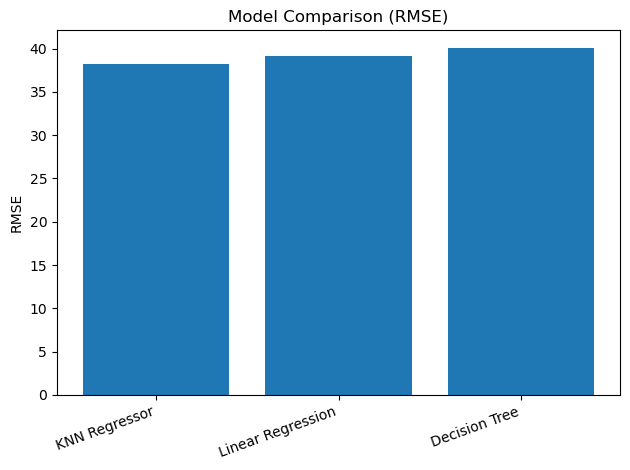

Saved evaluation plot: models\model_rmse_comparison.png


In [13]:
# Visualization
def save_eval_plot(results: pd.DataFrame):
    plt.figure()
    plt.bar(results["Model"], results["RMSE"])
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("RMSE")
    plt.title("Model Comparison (RMSE)")
    plt.tight_layout()
    out_path = os.path.join(MODELS_DIR, "model_rmse_comparison.png")
    plt.savefig(out_path, dpi=180)
    plt.show() # Show inline as well
    return out_path

plot_path = save_eval_plot(results)
print("Saved evaluation plot:", plot_path)


Visualizing Best Model Performance...


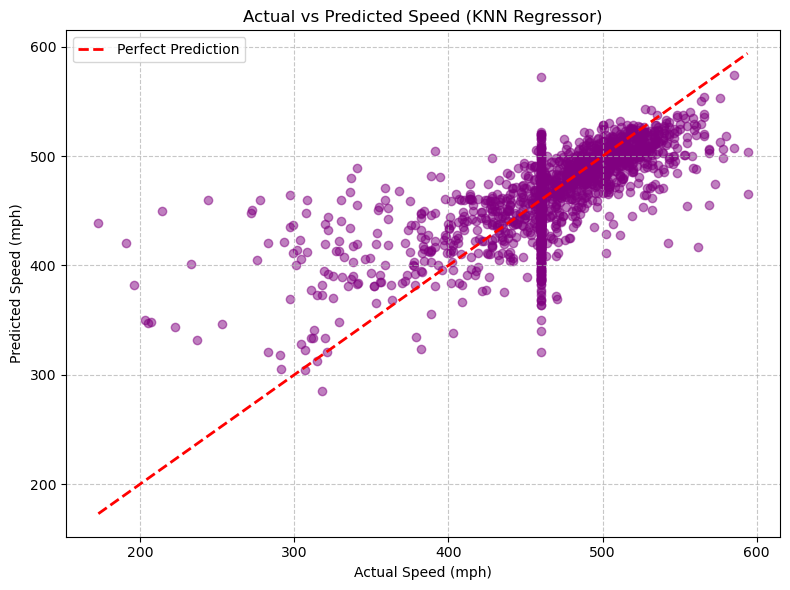

Saved actual vs predicted plot: models\actual_vs_predicted_best_model.png


In [14]:
def plot_actual_vs_predicted(model, X_test, y_test, model_name):
    preds = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    
    plt.scatter(y_test, preds, alpha=0.5, color='purple')
    
    # Diagonal reference line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")
    
    plt.xlabel("Actual Speed (mph)")
    plt.ylabel("Predicted Speed (mph)")
    plt.title(f"Actual vs Predicted Speed ({model_name})")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    
    filename = "actual_vs_predicted_best_model.png"
    out_path = os.path.join(MODELS_DIR, filename)
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved actual vs predicted plot: {out_path}")

print("\nVisualizing Best Model Performance...")
plot_actual_vs_predicted(best_pipe, X_test, y_test, best_name)


In [15]:
# Save Predictor
predictor_path = os.path.join(MODELS_DIR, "predictor.pkl")
joblib.dump(best_pipe, predictor_path)
print("Saved best predictor:", predictor_path, "| Best =", best_name)

# Save evaluation table
eval_path = os.path.join(MODELS_DIR, "model_evaluation.csv")
results.to_csv(eval_path, index=False)
print("Saved evaluation table:", eval_path)

Saved best predictor: models\predictor.pkl | Best = KNN Regressor
Saved evaluation table: models\model_evaluation.csv


In [16]:
# RECOMMENDER SYSTEM
def build_recommender(profiles: pd.DataFrame):
    # Feature space for recommendation (content-based)
    numeric_features = ["avg_alt", "avg_mph", "mean_lat", "mean_long", "log_flight_count"]
    categorical_features = ["manufacturer", "model", "reg_state"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ]
    )

    X = profiles[numeric_features + categorical_features]
    X_vec = preprocessor.fit_transform(X)

    nn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=10)
    nn.fit(X_vec)

    return nn, preprocessor

print("Building recommender...")
nn, rec_preprocess = build_recommender(profiles)

nn_path = os.path.join(MODELS_DIR, "recommender_nn.pkl")
rec_prep_path = os.path.join(MODELS_DIR, "recommender_preprocess.pkl")
joblib.dump(nn, nn_path)
joblib.dump(rec_preprocess, rec_prep_path)
print("Saved recommender:", nn_path)
print("Saved recommender preprocessor:", rec_prep_path)

Building recommender...
Saved recommender: models\recommender_nn.pkl
Saved recommender preprocessor: models\recommender_preprocess.pkl


In [17]:
print("DONE. All models built and saved.")

DONE. All models built and saved.
